In [289]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
import glob
import pandas as pd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from AnaUtil import *
from bisect import bisect_left
from tqdm import tqdm
import datetime as dt
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [290]:
Year = "2019"
Month = "12"
Day = "15"
BeadNumber =1
folder_basic = r"/data/new_trap/"+ Year + Month + Day + "/Bead"+str(BeadNumber)

In [291]:
def get_harmonics_with_sideband(input_psd,shake_freq,no_harmonics,res_factor=10,sum_range=0,sideband_spacing=-7,plot=False):
    harmonics = []
    sideband = []
    FreqTF = np.arange(shake_freq,(shake_freq*no_harmonics+shake_freq),shake_freq)
    for i in range(no_harmonics):
        harmonics_sum = input_psd[shake_freq*res_factor*(i+1)]+ input_psd[(shake_freq+sum_range)*res_factor*(i+1)]+input_psd[(shake_freq-sum_range)*res_factor*(i+1)]
        harmonics.append(harmonics_sum)
        #side_up = input_psd[(shake_freq+sideband_spacing)*res_factor*(i+1)]
        #side_down = input_psd[(shake_freq-sideband_spacing)*res_factor*(i+1)]
        #sideband.append(np.divide(np.sum(side_up,side_down),2))
        sideband.append(input_psd[(shake_freq+sideband_spacing)*res_factor*(i+1)])
    if(plot==True):
        plt.plot(FreqTF,harmonics, marker ="o", linestyle ="")
        plt.yscale("log")
        #plt.show()
    #print(harmonics_sum)
    return FreqTF,harmonics,sideband     

In [292]:
def data_to_amp_and_phase(data,fsamp,res):
    data_det=signal.detrend(data)
    x=data_det[0]
    y=data_det[1]
    z=data_det[2]
    res = res
    fsamp = fsamp # stays hard coded for now
    freqs=np.linspace(0,fsamp/2,(res/2)+1)    # change
    xFFT=np.fft.rfft(data_det[0])
    yFFT=np.fft.rfft(data_det[1])
    zFFT=np.fft.rfft(data_det[2])
    norm = np.sqrt(2 / (res* fsamp))
    xpsd = norm**2 * (xFFT * xFFT.conj()).real
    ypsd = norm**2 * (yFFT * yFFT.conj()).real
    zpsd = norm**2 * (zFFT * zFFT.conj()).real
    xphase=np.angle(xFFT)
    yphase=np.angle(yFFT)
    zphase=np.angle(zFFT)
    return xpsd,ypsd,zpsd,xphase,yphase,zphase

In [652]:
def harmonics_processor_basic(folder,filename_input,filename_output,max_file=5,shake_freq=13,no_harmonics=10,fsamp=5000,res=50000,res_factor=10,save_file=True):
    path="/harmonics/"
    #try:
    #    os.mkdir(path)
    #except OSError:
    #    print ("Creation of the directory %s failed" % path)
    #else:
    #    print ("Successfully created the directory %s " % path)
        
    # load files and initialize processor
    files = load_dir_sorted(folder, file_prefix =filename_input, max_file=max_file)

    harmonic_list_x, sideband_list_x, phase_list_x, sidephase_list_x =([] for i in range(4))
    harmonic_list_y, sideband_list_y, phase_list_y, sidephase_list_y =([] for i in range(4))
    harmonic_list_z, sideband_list_z, phase_list_z, sidephase_list_z =([] for i in range(4))

    xmean_list,ymean_list,zmean_list = ([] for i in range(3))
    cant_xpos_list,cant_ypos_list,cant_zpos_list=([] for i in range(3))      
    freq_list,time_stamp_list = ([] for i in range(2))
    test_info =0
    for i in tqdm(np.arange(0,len(files),1)):
        #print(files[i].fname)
        data = files[i].xyz2
        
        xmean_list.append(np.mean(files[i].x2))
        ymean_list.append(np.mean(files[i].y2))
        zmean_list.append(np.mean(files[i].z2))
        
        test_info = files[0].cant_pos[1]
        cant_xpos_list.append(np.mean(files[i].cant_pos[0]))
        cant_ypos_list.append(np.mean(files[i].cant_pos[1]))
        cant_zpos_list.append(np.mean(files[i].cant_pos[2]))
        
        time_stamp_list.append(files[i].time[0])
        
        FFT_and_phases = data_to_amp_and_phase(data,fsamp,res)
        freqs,harmonics_x,sidebands_x = get_harmonics_with_sideband(FFT_and_phases[0],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,harmonics_y,sidebands_y = get_harmonics_with_sideband(FFT_and_phases[1],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,harmonics_z,sidebands_z = get_harmonics_with_sideband(FFT_and_phases[2],shake_freq=shake_freq,no_harmonics=no_harmonics)
        
        freq_list.append(freqs)
        
        harmonic_list_x.append(np.sqrt(harmonics_x))     
        harmonic_list_y.append(np.sqrt(harmonics_y))     
        harmonic_list_z.append(np.sqrt(harmonics_z))     
        
        sideband_list_x.append(np.sqrt(sidebands_x))     
        sideband_list_y.append(np.sqrt(sidebands_y))     
        sideband_list_z.append(np.sqrt(sidebands_z))     

        
        _,phases_x,sidephases_x = get_harmonics_with_sideband(FFT_and_phases[3],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,phases_y,sidephases_y = get_harmonics_with_sideband(FFT_and_phases[3],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,phases_z,sidephases_z = get_harmonics_with_sideband(FFT_and_phases[3],shake_freq=shake_freq,no_harmonics=no_harmonics)
        
        phase_list_x.append(phases_x)
        phase_list_y.append(phases_y)
        phase_list_z.append(phases_z)

        sidephase_list_x.append(sidephases_x)
        sidephase_list_y.append(sidephases_y)
        sidephase_list_z.append(sidephases_z)


    # make the dataframe and fill it
    df = pd.DataFrame()
    df["start_time"]=time_stamp_list
    df["x_mean"]=xmean_list
    df["y_mean"]=ymean_list
    df["z_mean"]=zmean_list
    df["attractor_position_x"]=cant_xpos_list
    df["attractor_position_y"]=cant_ypos_list
    df["attractor_position_z"]=cant_zpos_list
    # frequencies
    df["frequency"] = freq_list
    df["amplitude_x"] = harmonic_list_x
    df["amplitude_y"] = harmonic_list_y
    df["amplitude_z"] = harmonic_list_z
    
    df["phase_x"] = phase_list_x
    df["phase_y"] = phase_list_y
    df["phase_z"] = phase_list_z
    df["sideband_amplitude_x"] = sideband_list_x
    df["sideband_amplitude_y"] = sideband_list_y
    df["sideband_amplitude_z"] = sideband_list_z

    df["sideband_phase_x"] = sidephase_list_x
    df["sideband_phase_y"] = sidephase_list_y
    df["sideband_phase_z"] = sidephase_list_z    
    
    if(save_file==True):
            if(os.path.isfile(folder+"harmonics/harmonics_basic_%s.pkl" %filename_output)==False):
                df.to_csv(folder+"harmonics/harmonics_basic_%s.csv" %filename_output,index=False)
                df.to_pickle(folder+"harmonics/harmonics_basic_%s.pkl" %filename_output)
            else:print("File could not be saved, probably exists.")
    return df,test_info

In [653]:
def get_mean_and_sum_of_harmonics(df,no_harmonics=10):
    mean_list, std_list, sum_list, median_list=([] for i in range(4))
    for i in np.arange(0,no_harmonics,1):
        mean_list.append(list(pd.DataFrame.mean(df["amplitude_x"]))[i])
        sum_list.append(list(pd.DataFrame.sum(df["amplitude_x"]))[i])
    return mean_list,sum_list

In [654]:
def file_loader(folder_basic,folder_list):
    df_list = []
    for folder_list_entry in np.unique(folder_list):
        folder_shaking = "/Shaking/Shaking%d/" % folder_list_entry
        folder = folder_basic + folder_shaking    
        for output_file_number in np.arange(0,folder_list.count(folder_list_entry),1):
            try:df = pd.read_pickle(folder+"harmonics/"+"harmonics_basic_shaking%d_%d.pkl" %(folder_list_entry,output_file_number))
            except:print("Did not load. File %s does not exist" %(folder+"harmonics/"+"harmonics_basic_shaking%d_%d.pkl" %(folder_list_entry,output_file_number)))
            df_list.append(df)
    return df_list    

In [683]:
df_list=[]
test_info_list = []
#distance_x_aerotech = [380,380,380,380,380]
#distance_x_aerotech = [385] * 17
#distance_x_aerotech = [388]*13
#distance_x_aerotech = [68,68]
distance_x_aerotech=[393]
test_info = 0
input_name = len(distance_x_aerotech)

for distances in distance_x_aerotech:
    print(distances)
    input_name = input_name - 1
    print(input_name)
    start = time.time()
    folder_shaking = "/Shaking/Shaking%d/" %distances
    folder = folder_basic + folder_shaking
    if(input_name==0 or input_name==1 or input_name==2):shake_freq=7
    elif(input_name==8): shake_freq=3
    else: shake_freq=13    
    df,test_info = harmonics_processor_basic(folder,filename_input="Shaking%d" %input_name,filename_output="shaking%s_%d" %(distances,input_name),max_file=100,shake_freq=shake_freq,no_harmonics=15,res_factor=10,save_file=True)
    #print(len(df))
    end = time.time()
    print(end-start)
    test_info_list.append(test_info)
    df_list.append(df)

 73%|███████▎  | 8/11 [00:00<00:00, 72.62it/s]

393
0
11  files in folder
11  files loaded


100%|██████████| 11/11 [00:00<00:00, 71.05it/s]

0.25110936164855957


2.070145549066531
103.50727745332655


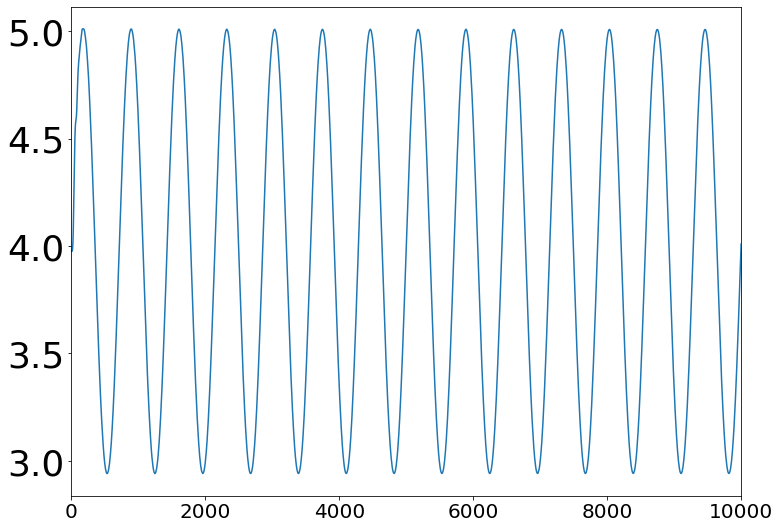

In [684]:
file = 0
plt.plot(test_info_list[file])
#plt.plot(test_info_list[2])

plt.xlim(0,10000)
print(np.max(test_info_list[file])-np.min(test_info_list[file]))
print(500/10.0*(np.max(test_info_list[file])-np.min(test_info_list[file])))

0


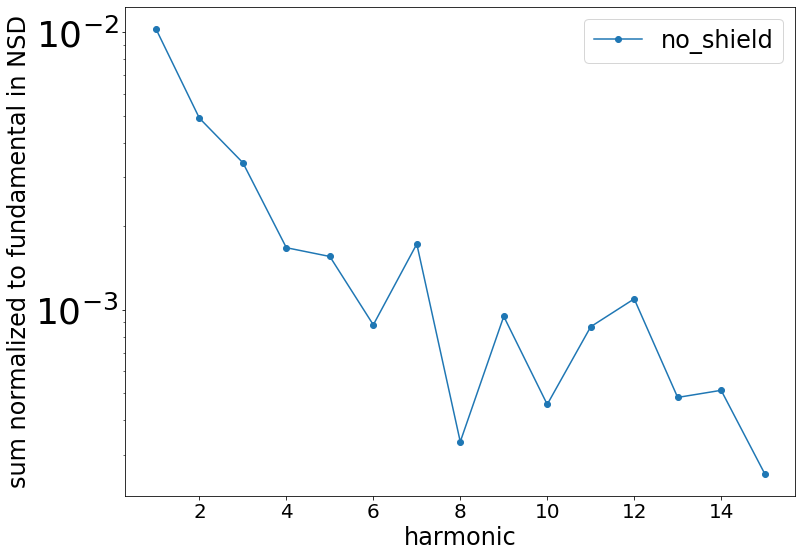

In [685]:
sum_list =[]
#legends_385 = ["+9V_shield_z38","+7V_shield_z36.5","+4.5V_rep_shield_z36.5","+4.5V_shield_z36.5","+2.5v_z36.5","rep_normal_shield_z34.5","lower_shield_z34.5","7hz_noservo","7hz_servo","stroke2V_z41.5","stroke2V_z40","stroke2V_z38","stroke2V_z36.5","stroke1.75V_z36.5","stroke0.0V","stroke2.0V","stroke1.75V"]
#legends_380 = ["0.5V","1.25V","1.75V","0V","2V"]
#legends_355 = ["in-n-out"]
#legends_330=["shaking"]
#legends_68=["no_shield","shield"]
#legends_358 = ["shaking","no shaking"]
#legends_388 = ["42.5_13_1.75","42.0_13_1.75","41.5_13_1.75","","","42_3_3","42_7_1.75","shield_touch_40_13_1.75","no shield","shield 7hz servo","1.75_38","1.75_40","1.75_38_1"]
legends_390 = ["no_shield","bkg","shield"]
for i in range(len(df_list)):
    if(i<20):
        print(i)
        meanws,sumws = get_mean_and_sum_of_harmonics(df_list[i],no_harmonics=15)
        sum_list.append(sumws)
        plt.plot(np.arange(1,16,1),np.divide(sumws,len(df_list[i])),linestyle="-",marker="o",label="%s" %legends_390[i] )
        plt.yscale("log")
        # plt.axhline(10)
        # plt.ylim(0,5)
        plt.ylabel(r"sum normalized to fundamental in NSD")
        plt.xlabel("harmonic")
        #plt.savefig("Results/Pocket_Characterization_20191205/normalized_2ndharm_sums_with_woshield.png",dpi=300,bbox_inches="tight")
        plt.legend()
plt.show()    

IndexError: list index out of range

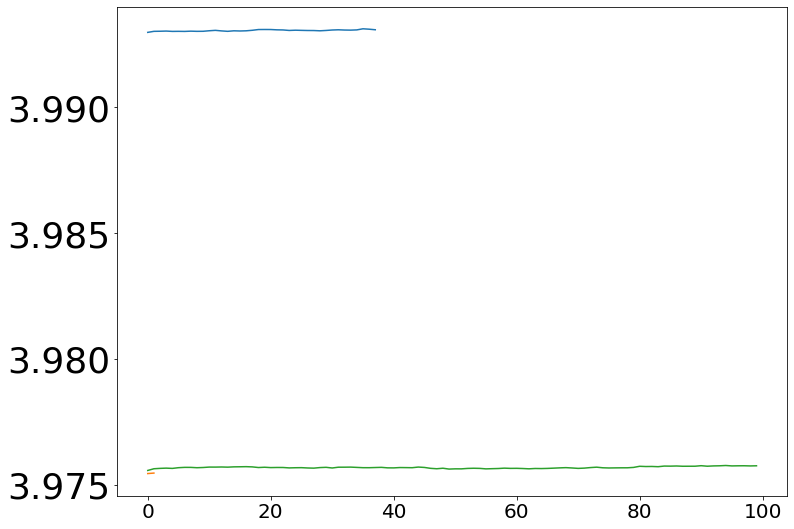

In [651]:
plt.plot(df_list[0]["attractor_position_y"])
plt.plot(df_list[1]["attractor_position_y"])
plt.plot(df_list[2]["attractor_position_y"])
plt.plot(df_list[3]["attractor_position_y"])
plt.plot(df_list[4]["attractor_position_y"])
plt.plot(df_list[5]["attractor_position_y"])
plt.plot(df_list[6]["attractor_position_y"])
